In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import rho
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
from matplotlib.pyplot import cm
import xrft

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## For CM2.6 data

In [353]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs=xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
lat_u=fs['geolat_c']
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_t']/360 *2*np.pi);
#dx = fs['dxt']; dy = fs['dyt']; dxy= (dx**2+dy**2)**0.5
#print(os,fs)

%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history

u = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_minibling_field_v.nc')['v']
salt = xr.open_dataset('02020101.ocean_minibling_field_salt.nc')['salt']
temp = xr.open_dataset('02020101.ocean_minibling_field_temp.nc')['temp']

z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

#print(thickness)



/net2/smg/documents/OMDT/analysis_CM2p6/grids
/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history


## For CM2.5 data

In [275]:
%cd /work/eay/CM2.6/CM2.5_data
fs = xr.open_dataset('02020101.ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
lat_u=fs['geolat_c']

u = xr.open_dataset('02020101.ocean_bgc_physics_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_bgc_physics_field_v.nc')['v']
temp = xr.open_dataset('02020101.ocean_bgc_physics_field_temp.nc')['temp']
salt = xr.open_dataset('02020101.ocean_bgc_physics_field_salt.nc')['salt']
z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_bgc_physics_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})


# print(thickness)

/work2/eay/CM2.6/CM2.5_data


## For CM2-1deg data

In [329]:
%cd /work/eay/CM2.6/CM2_1deg_data
fs = xr.open_dataset('02000101.ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
lat_u=fs['geolat_c']

u = xr.open_dataset('02000101.ocean_bgc_physics_field_u.nc')['u']
v = xr.open_dataset('02000101.ocean_bgc_physics_field_v.nc')['v']
temp = xr.open_dataset('02000101.ocean_bgc_physics_field_temp.nc')['temp']
salt = xr.open_dataset('02000101.ocean_bgc_physics_field_salt.nc')['salt']
z = u.st_ocean
z_edges  = xr.open_dataset('02000101.ocean_bgc_physics_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

# print(thickness)

/work2/eay/CM2.6/CM2_1deg_data


In [354]:
#AT ONE POINT in Argentine Basin:
lati=767; loni=2500; #2374 CM2.6
#lati=297; loni=1000; #949 CM2.5
#lati= 38; loni= 250; #238 CM2-1deg

#lati=38; loni=250; 

In [355]:
mask_2D = depth*0+1.

In [356]:
vorticity1=u[0,0,:,:].differentiate('yu_ocean')*360/(2*np.pi*6378000)
vorticity2=v[0,0,:,:].differentiate('xu_ocean')*360/(2*np.pi*6378000*np.cos(u.yu_ocean*np.pi/180))
vorticity=vorticity2-vorticity1

In [357]:
vorticity1.shape

(2700, 3600)

In [358]:
print(vorticity)
vorticity=np.array(vorticity)*mask_2D
print(vorticity)

<xarray.DataArray (yu_ocean: 2700, xu_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    st_ocean  float64 5.034
    time      object 0202-01-03 12:00:00
<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * y

In [359]:
print(lon[lati,loni].values,lat[lati,loni].values)

-29.950000762939453 -43.023224


In [361]:
#FOR A 2D REGION:
region = 130 #130
u_s = u[:,0,lati-region:lati+region,loni-region:loni+region].fillna(0)
u_s = u_s-u_s.mean('time')
v_s = v[:,0,lati-region:lati+region,loni-region:loni+region].fillna(0)
v_s = v_s-v_s.mean('time')



Text(0.5, 1.0, 'Depth [m]')

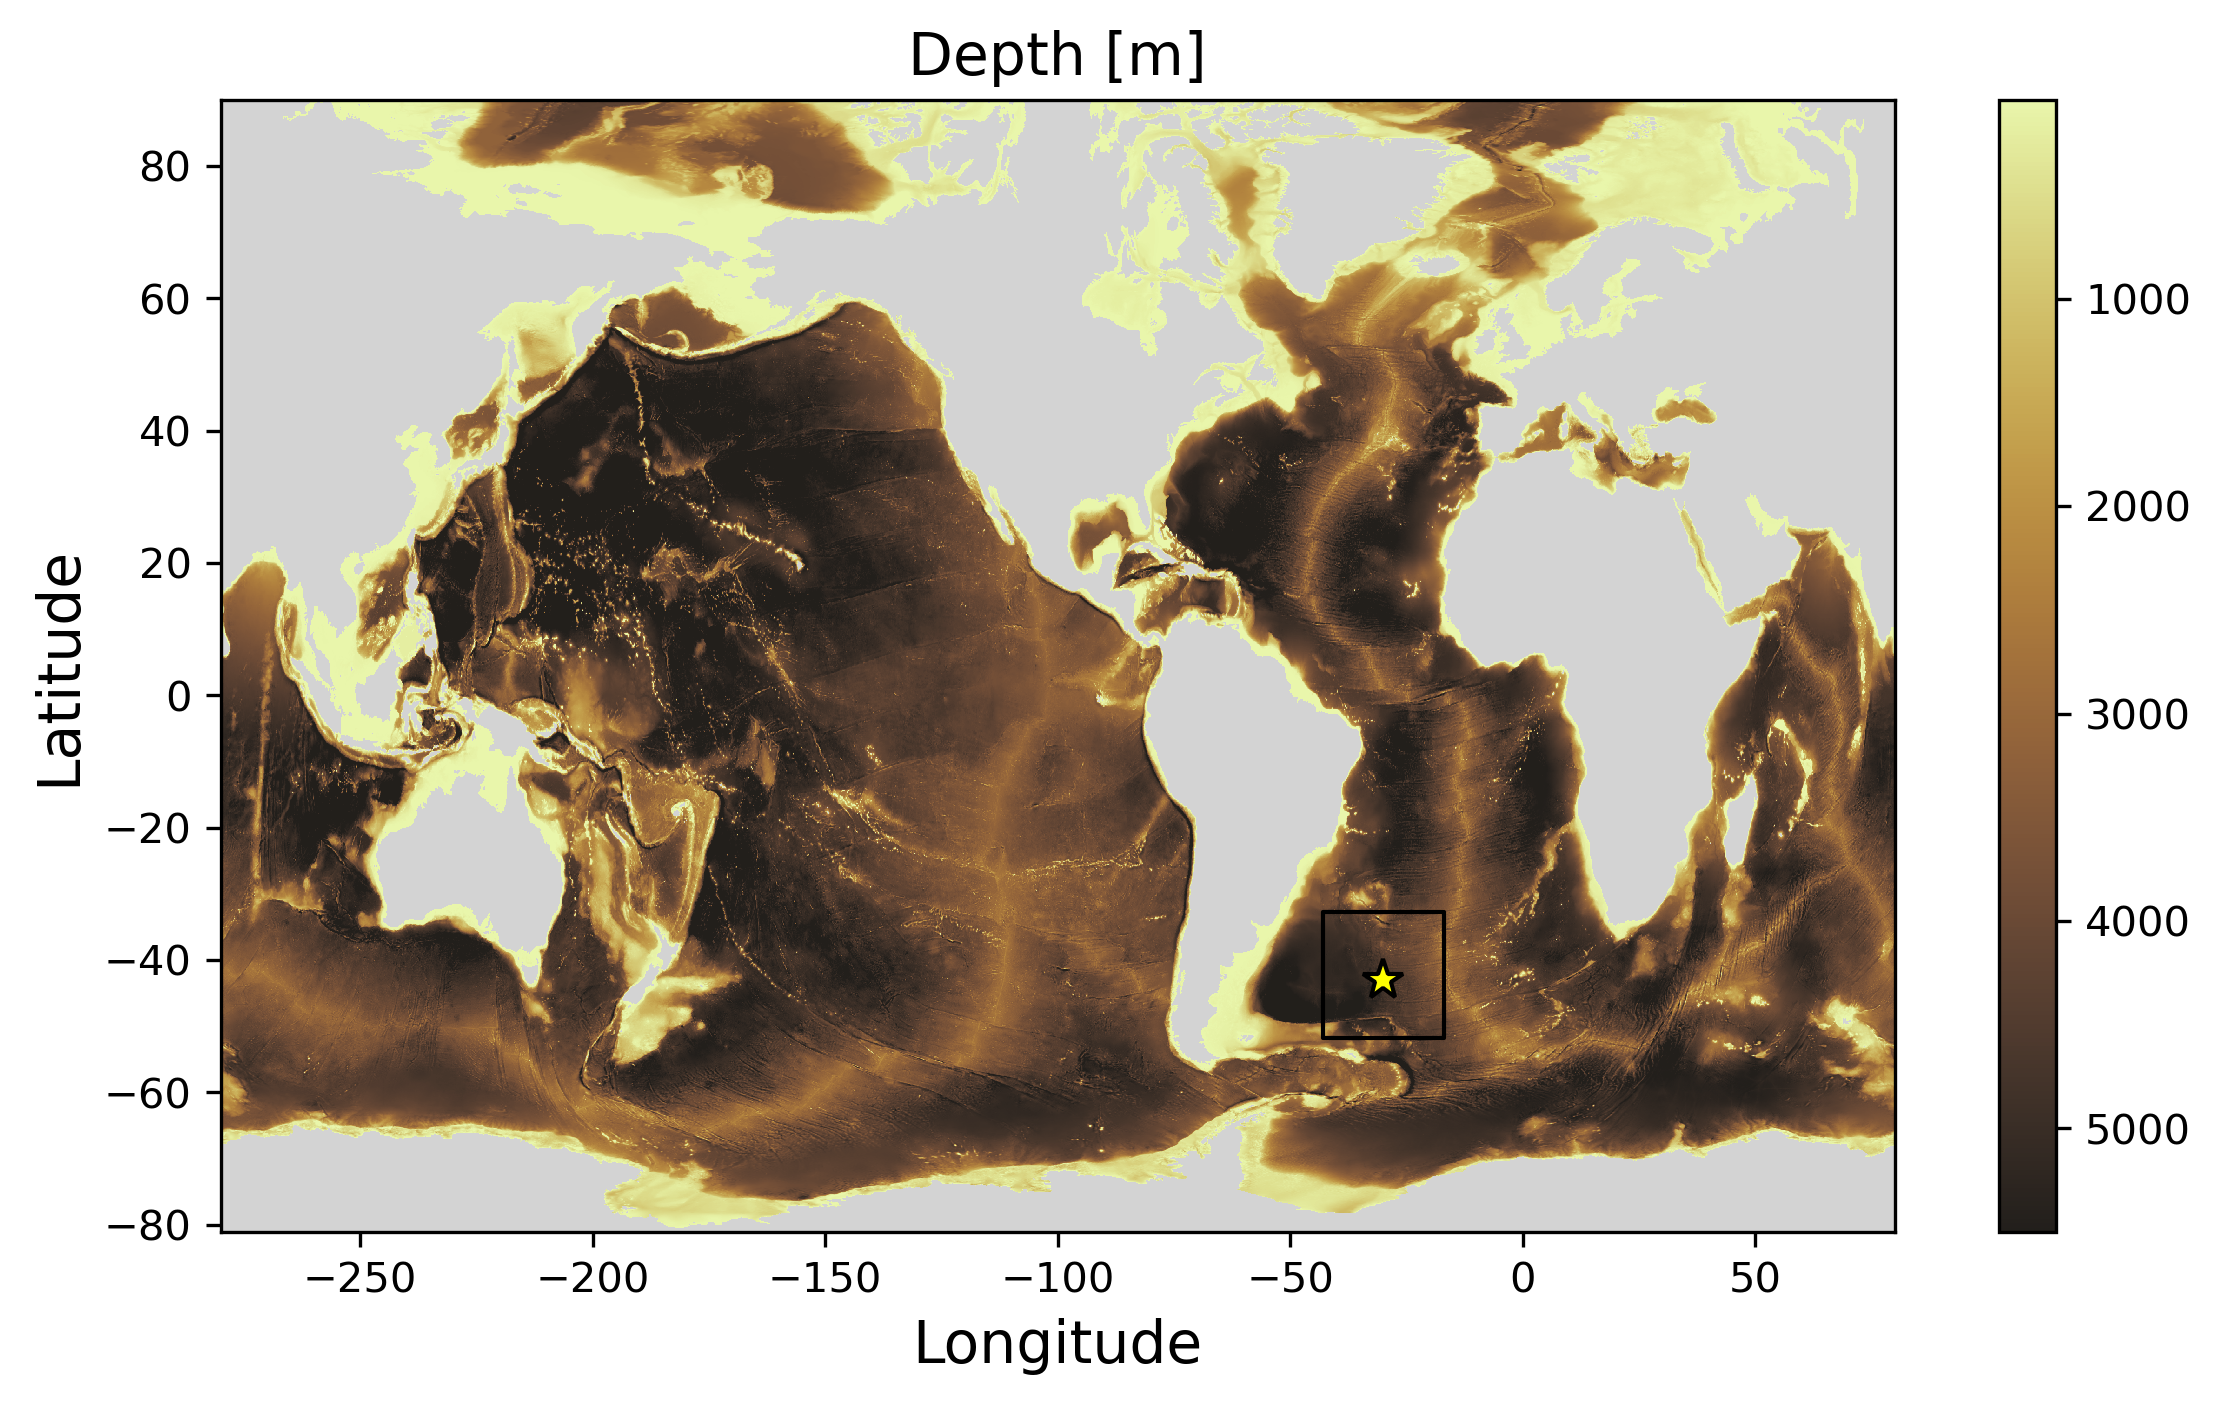

In [393]:
fig = plt.figure(figsize=(9, 5), dpi= 300, facecolor='w', edgecolor='k')

plot1=depth.plot(cmap=cmocean.cm.turbid,add_colorbar=False)
cb=plt.colorbar(plot1)
cb.ax.invert_yaxis()
plt.plot(lon[lati,loni],lat[lati,loni],'*',markerfacecolor=[1,1,0],markeredgecolor='k',markersize=10)
hatch = plt.fill_between([lon[lati,loni-region],lon[lati,loni+region]],lat[lati-region,loni],lat[lati+region,loni],color="none",edgecolor='k')

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Depth [m]',fontsize=14)

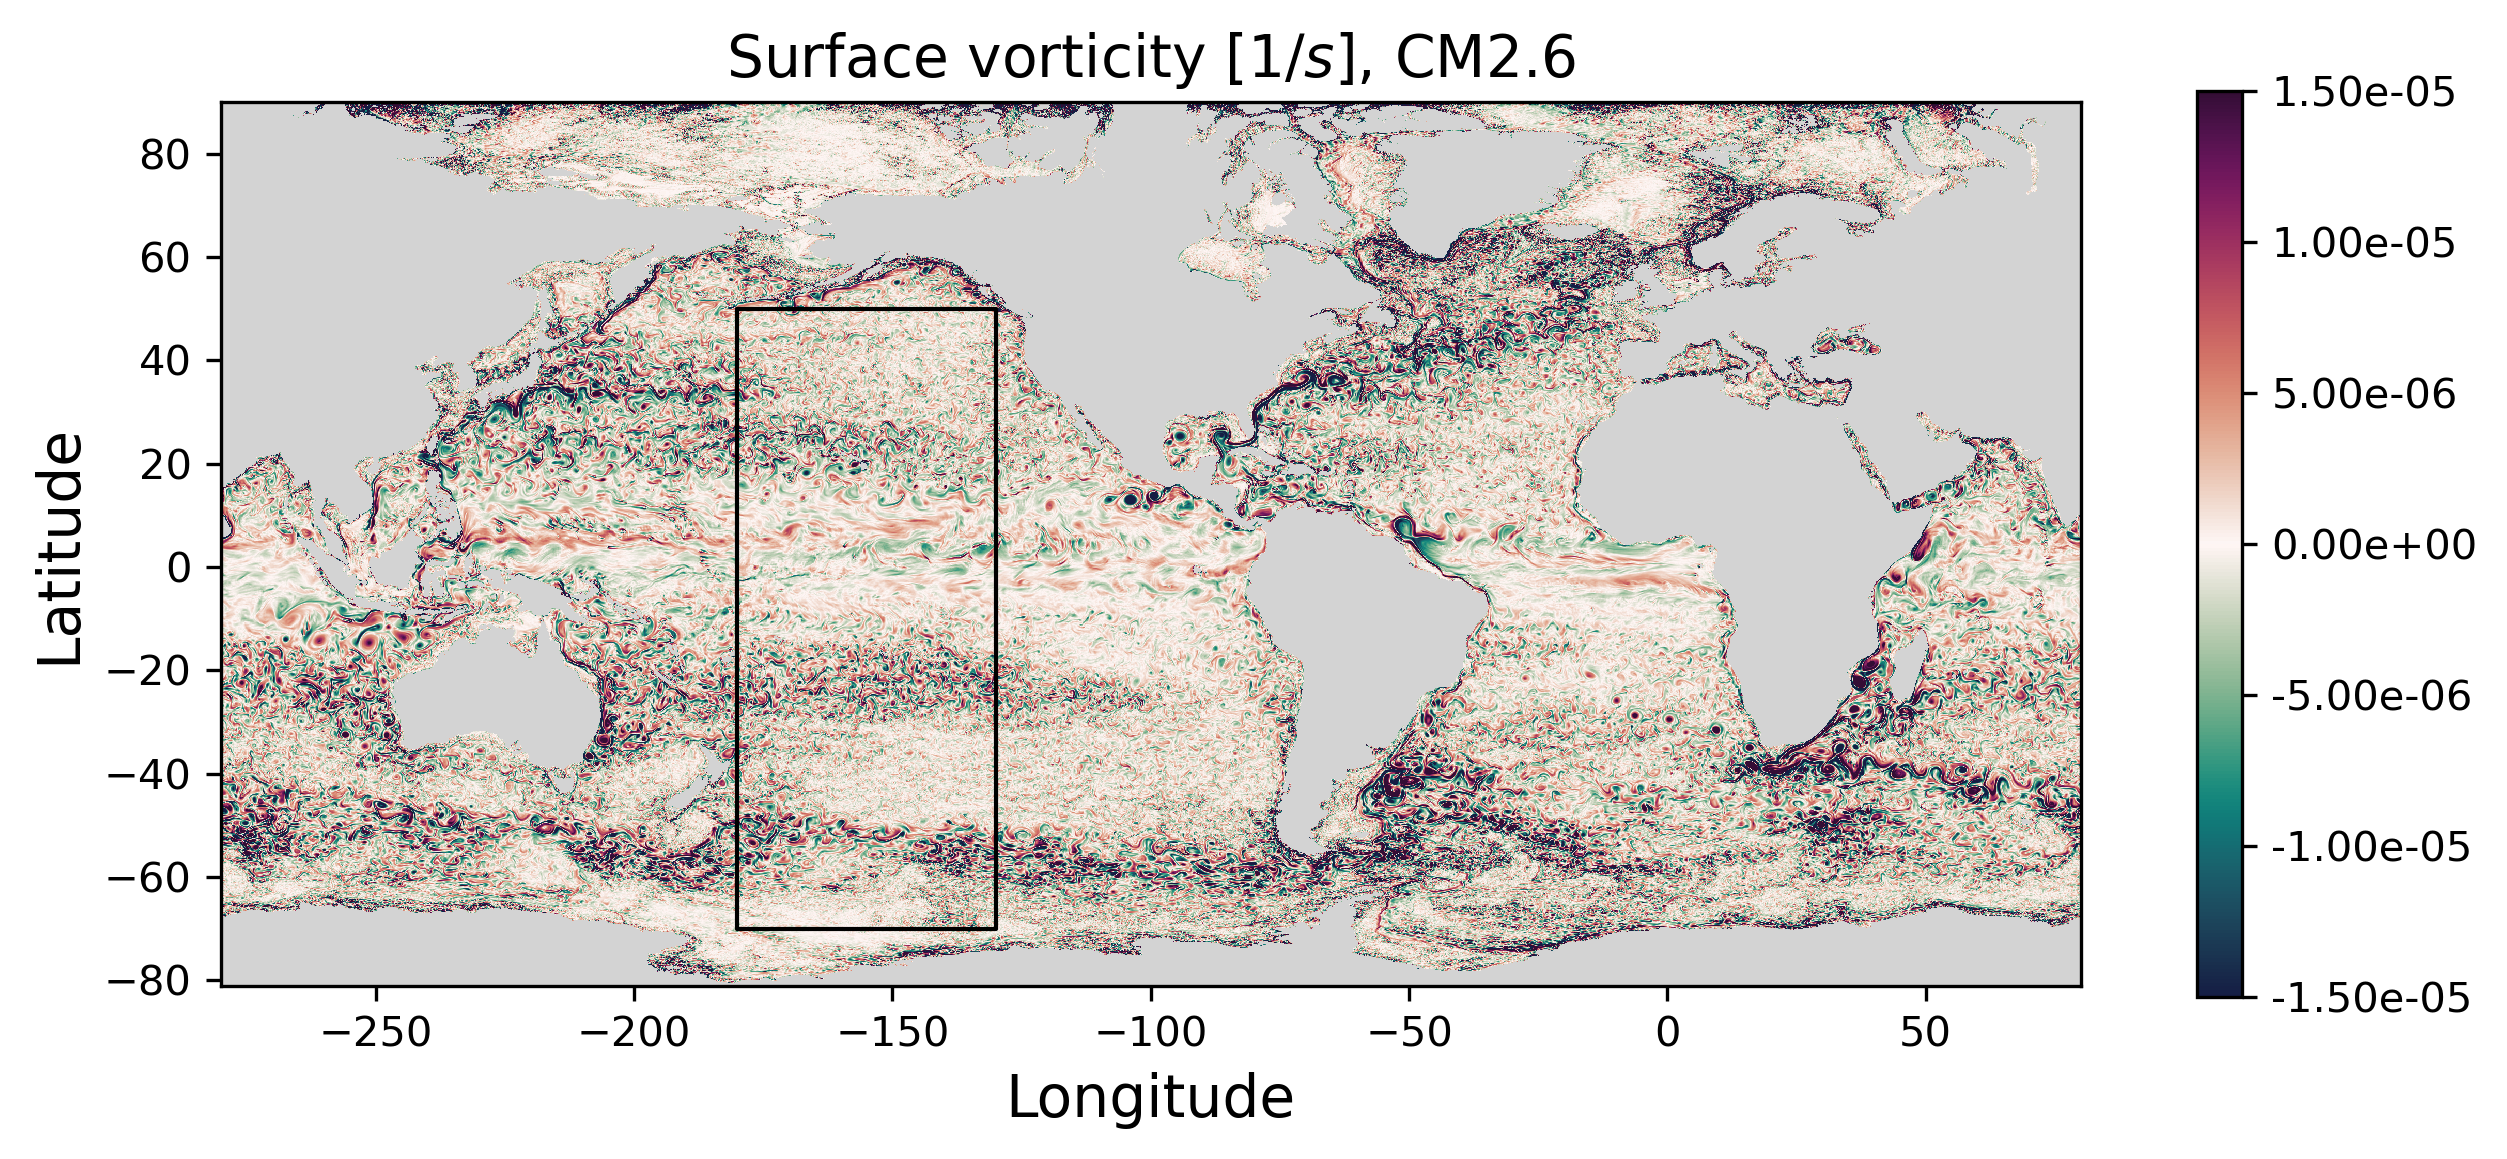

In [408]:
fig = plt.figure(figsize=(10, 4), dpi= 300, facecolor='w', edgecolor='k')

plot1=vorticity.plot(vmin=-1.5e-5,vmax=1.5e-5,cmap=cmocean.cm.curl,add_colorbar=False)#,xlim=[-70,-10],ylim=[-70,-20])
plt.colorbar(plot1, format='%.2e')
#plt.plot(lon[lati,loni],lat[lati,loni],'*',markerfacecolor=[1,1,0],markeredgecolor='k',markersize=10)
#hatch = plt.fill_between([-180,-130],-70,50,color="none",edgecolor='k')
# hatch = plt.fill_between([lon[530,1850-region],lon[530,1850+region]],lat[530-region,1850],lat[530+region,1850],color="none",edgecolor='k')
# hatch = plt.fill_between([lon[1724,1354-region],lon[1724,1354+region]],lat[1724-region,1354],lat[1724+region,1354],color="none",edgecolor='k')
# hatch = plt.fill_between([lon[1800,2500-region],lon[1800,2500+region]],lat[1800-region,2500],lat[1800+region,2500],color="none",edgecolor='k')

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Surface vorticity [$1/s$], CM2.6',fontsize=14)
plt.gca().set_aspect('equal')
#
# plot1.set_xlim([-100,0])
# plot1.set_ylim([-80,-20])

In [347]:
%%time
# xnew= np.abs((u_s.xu_ocean.values)*(np.pi*6378*np.cos(u_s.yu_ocean*np.pi/180).values)/180) #*np.cos(u_s.yu_ocean[region]*np.pi/180)
# xnew = xnew - np.min(xnew)
# ynew= np.abs((u_s.yu_ocean)*np.pi*6378/180).values
# ynew= ynew- np.min(ynew)

mean_lat=np.abs(np.nanmean(u_s.yu_ocean))
dx_lat=111*np.cos(mean_lat*np.pi/180)

xnew= (np.linspace(0,region/1*dx_lat,region*2)) #in km
ynew= (np.linspace(0,region/1*111,region*2))    #in km



unew = xr.DataArray(u_s.values, coords=[u_s.time,ynew,xnew],dims=["time","ynew","xnew"])
vnew = xr.DataArray(v_s.values, coords=[u_s.time,ynew,xnew],dims=["time","ynew","xnew"])


CPU times: user 3.63 ms, sys: 0 ns, total: 3.63 ms
Wall time: 3.48 ms


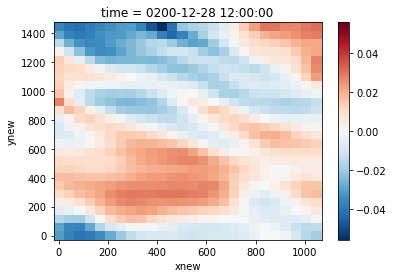

In [348]:
(unew[-1,:,:]-unew.mean('time')).plot()

In [349]:
#uiso2 = xrft.isotropic_power_spectrum(unew[0:40,0:40],dim=['ynew','xnew'],detrend='linear').compute()

uiso2 = xrft.isotropic_power_spectrum(unew,dim=['ynew','xnew'],scaling="density",window='hann', detrend='linear').compute() # scaling="density",window='hann', detrend='linear',
viso2 = xrft.isotropic_power_spectrum(vnew,dim=['ynew','xnew'], scaling="density",window='hann', detrend='linear').compute() #,

ekeiso = .5*(uiso2 + viso2)

#nk = int(len(ekeiso[0,:])/2.)

#ekeiso=ekeiso[:,nk+1:]    # half of the latitude array size
#wavenumber= (ekeiso.freq_r*1e3*2*np.pi)
#uiso2 = xrft.isotropic_power_spectrum(u_small,dim=['x5km','y5km'], detrend='linear').compute()



Text(0.5, 0, '$\\kappa_r (1/km)$')

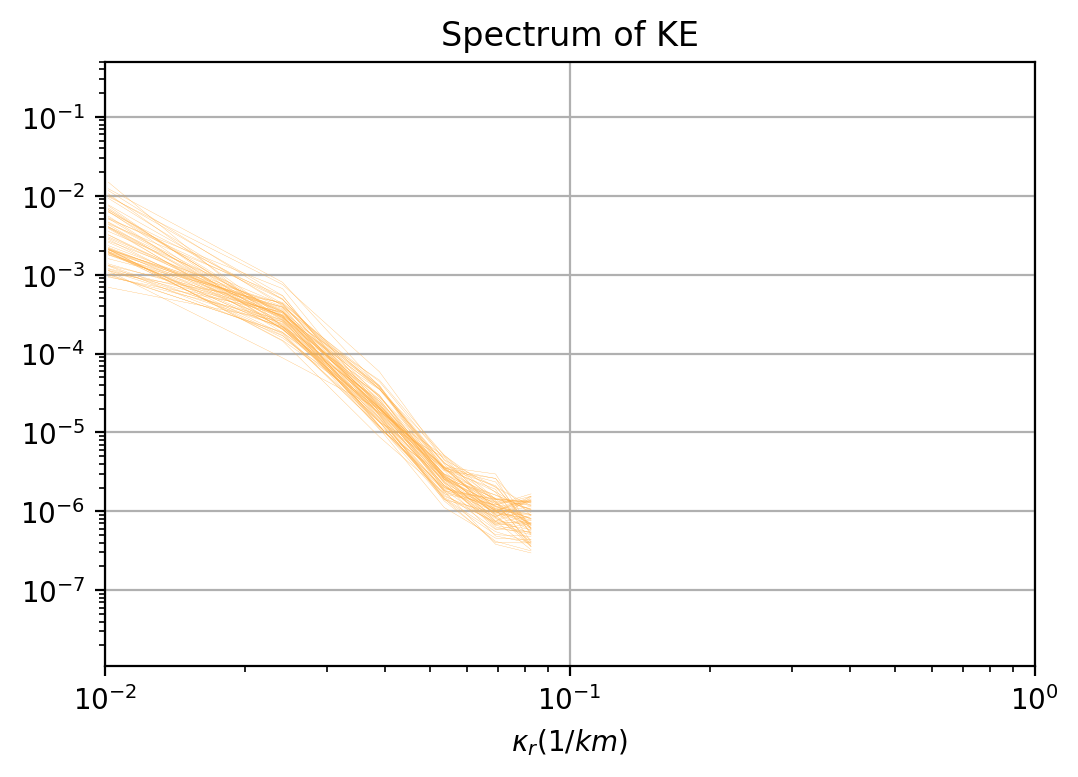

In [352]:
fig, ax = plt.subplots(figsize=(6,4),dpi=200)

for i in range(0,73):

    plt.plot((ekeiso.freq_r*2*np.pi), ekeiso[i],'-',color='#FFAE42',linewidth=.1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber

plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim([1.1e-8,.5])
plt.xlim([1e-2, 1e0])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
#plt.legend(fontsize=14)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [58]:
wavenumber21=wavenumber
ekeiso21=ekeiso